# **Object detection using YOLO model on Vedai dataset**

In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image

**clone vedai dataset from github**

In [2]:
!git clone https://github.com/mr8bit/vedai.git
%cd /content/vedai
!python xml_to_csv.py

Cloning into 'vedai'...
remote: Enumerating objects: 8913, done.
remote: Total 8913 (delta 0), reused 0 (delta 0), pack-reused 8913
Receiving objects: 100% (8913/8913), 1.50 GiB | 39.41 MiB/s, done.
Resolving deltas: 100% (3671/3671), done.
/content/vedai
Work on: /content/vedai/images/train/751.xml
Work on: /content/vedai/images/train/11416.xml
Work on: /content/vedai/images/train/15915.xml
Work on: /content/vedai/images/train/345.xml
Work on: /content/vedai/images/train/490.xml
Work on: /content/vedai/images/train/3809.xml
Work on: /content/vedai/images/train/2303.xml
Work on: /content/vedai/images/train/1770.xml
Work on: /content/vedai/images/train/20991.xml
Work on: /content/vedai/images/train/20986.xml
Work on: /content/vedai/images/train/20962.xml
Work on: /content/vedai/images/train/278.xml
Work on: /content/vedai/images/train/10660.xml
Work on: /content/vedai/images/train/10852.xml
Work on: /content/vedai/images/train/21476.xml
Work on: /content/vedai/images/train/509.xml
Work 

In [3]:
train_path  = "/content/vedai/images/train"
test_path  = "/content/vedai/images/test"
annot = "/content/vedai/data"

a = os.listdir(train_path)
for item in a:
    if item.endswith(".xml"):
        os.remove(os.path.join(train_path, item))

b = os.listdir(test_path)
for item in b:
    if item.endswith(".xml"):
        os.remove(os.path.join(test_path, item))

# **build dataset**
build dataset format as yolov5 is expecting

In [11]:
%cd /content
!python build_yolov5_dataset.py \
    --input_dir  /content/vedai/images/train/ \
    --output_dir /content/notebooks/YOLOV5/vedai_data \
    --train /content/vedai/data/train_labels.csv \
    --valid /content/vedai/data/test_labels.csv

/content
/content/build_yolov5_dataset.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_df.drop_duplicates(inplace=True)

preparing proper dataset format for YOLOV5 has been finished

preparing proper dataset format for YOLOV5 has been finished


## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [13]:
import glob
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOV5 Repository and Train the model on Vedai dataset

In [14]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 16008, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 16008 (delta 22), reused 20 (delta 13), pack-reused 15967
Receiving objects: 100% (16008/16008), 14.68 MiB | 18.60 MiB/s, done.
Resolving deltas: 100% (10988/10988), done.


In [15]:
# Create configuration
import yaml
config = {'train': '/content/notebooks/YOLOV5/vedai_data/train/images',
         'val': '/content/notebooks/YOLOV5/vedai_data/valid/images',
         'nc': 2,
         'names': ['car', 'notcar']}
if not os.path.exists('data.yaml'):
    with open("data.yaml", "w+") as file:
        yaml.dump(config, file, default_flow_style=False)

In [19]:
%cd /content/yolov5/
TRAIN = True
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5n.pt \
    --img 640 --epochs 20 --batch-size 32 --name {RES_DIR}

/content/yolov5
Current number of result directories: 0
results_1
requirements: Ultralytics requirement ['gitpython'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 12.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 4.3s, installed 1 package: ['gitpython']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

train: weights=yolov5n.pt, cfg=, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results_1, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=No

## Check Out the Validation Predictions and Inference

In this section, we will check out the predictions of the validation images saved during training. Along with that, we will also check out inference of images.
### Visualization and Inference Utilities
We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [22]:
# Function to show validation predictions saved during training.
import cv2
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

def visualize(INFER_DIR , measure_list ):
# Visualize inference images.
    INFER_PATH = f"runs/train/{INFER_DIR}"
    infer_images = [os.path.join(INFER_PATH ,  measure)  for measure in  measure_list ]
    print(infer_images)
    for pred_image in infer_images:
        image = np.array(Image.open(pred_image))
        plt.figure(figsize=(19, 16))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

confusion_matrix.png				    opt.yaml	  train_batch0.jpg
events.out.tfevents.1697376602.5a6c8585414e.2259.0  P_curve.png   train_batch1.jpg
F1_curve.png					    PR_curve.png  train_batch2.jpg
hyp.yaml					    R_curve.png   val_batch0_labels.jpg
labels_correlogram.jpg				    results.csv   val_batch0_pred.jpg
labels.jpg					    results.png   weights
['runs/train/results_1/val_batch0_pred.jpg']


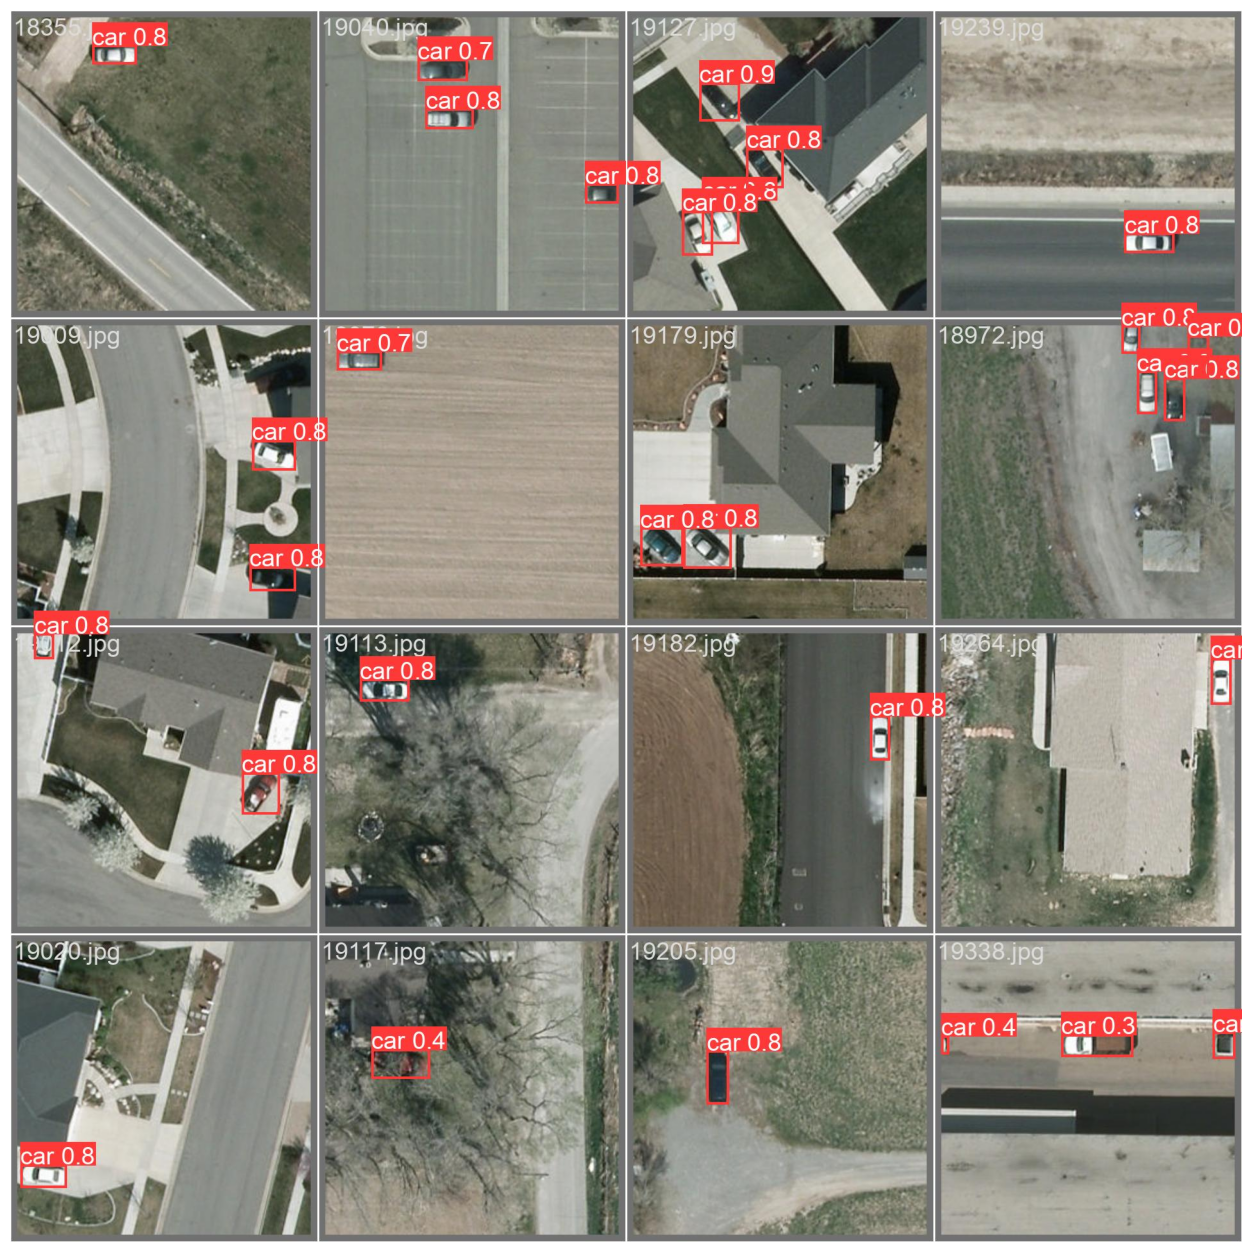

In [23]:
show_valid_results(RES_DIR)

get diagrams of loss , ... changes during training

['runs/train/results_1/results.png']


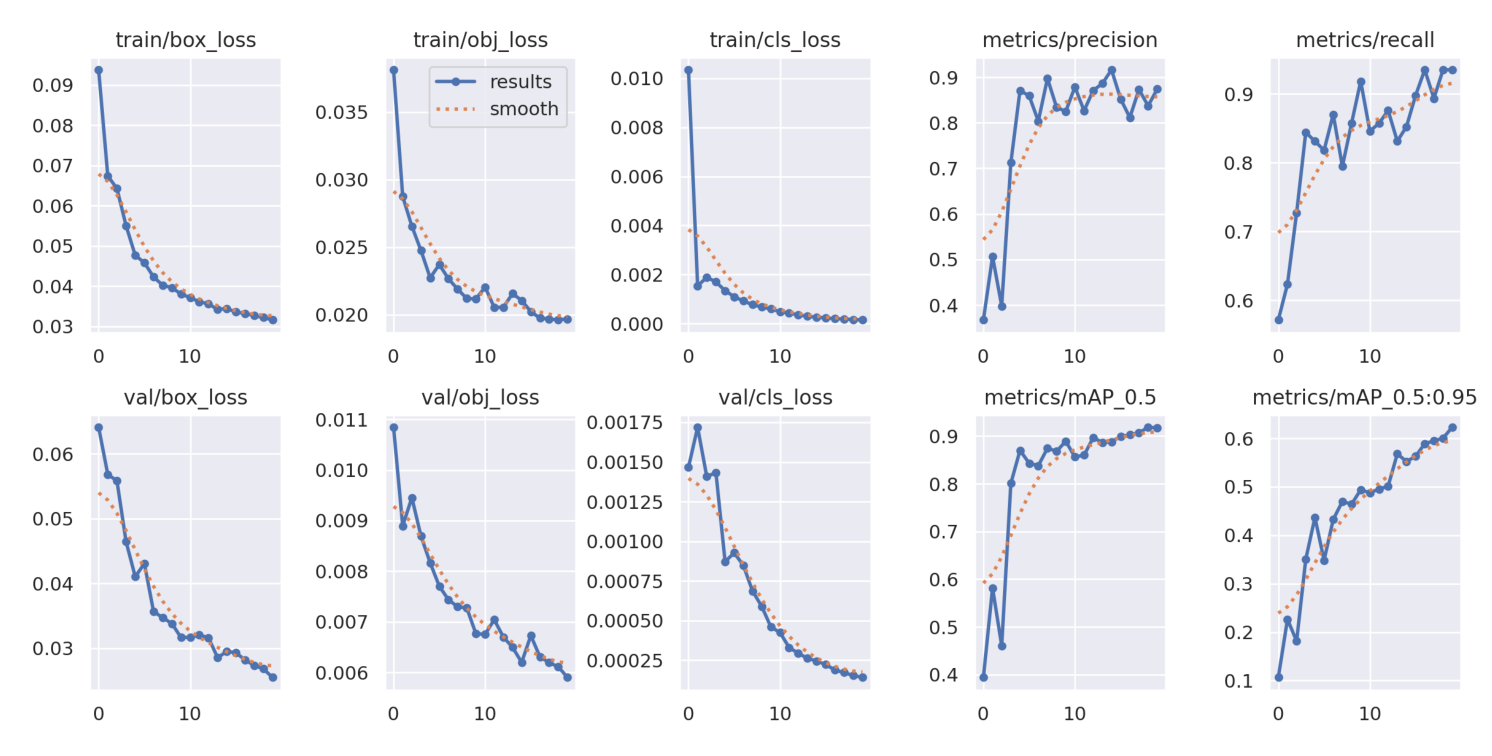

In [26]:
visualize('results_1' , ['results.png'] )